In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
ticker.EngFormatter.ENG_PREFIXES.update({9:"B"}) # For cleaner formatting

from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

from scipy.stats import trim_mean, bootstrap

sns.set()

In [2]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [3]:
# set color scheme
# blues = sns.color_palette("Blues")
# oranges = sns.color_palette("Oranges")

colors = sns.color_palette()

# baselines are PPO, SAC, TDMPC (no planning), TDMPC plannig, SHAC, FOWM
colors = {"SHAC": colors[0],
         "PPO": colors[2],
         "SAC": colors[3],
         # "TDMPC (no planning)": colors[4],
         "TDMPC2": colors[4],
         "FOWM": colors[1]}

# used to gather normalisation values
perf_scales = {}

# set legened helpers
fancy_legend = []
for k in colors.keys():
    patch = mpatches.Patch(color=colors[k], label=k)
    fancy_legend.append(patch)
    
# PPO_patch = mpatches.Patch(color=colors["PPO"], label='PPO')
# SAC_patch = mpatches.Patch(color=colors["SAC"], label='SAC')
# SVG_patch = mpatches.Patch(color=colors["SVG"], label='SVG')
# SHAC_patch = mpatches.Patch(color=colors["SHAC"], label='SHAC')
# AHAC_patch = mpatches.Patch(color=colors["AHAC"], label='AHAC')
# fancy_legend = [PPO_patch, SAC_patch, SVG_patch, SHAC_patch, AHAC_patch]

In [10]:
# General helper functions

fps_dict = {"ppo": {"anymal": 18300, "humanoid": 18500, "ant": 222800, "humanoidsnu": 21480, "hopper": 185000, "claw":169000},
            "sac": {"anymal": 3000, "humanoid": 3400, "ant":21000, "humanoidsnu": 6170 , "hopper":18200, "claw": 28300},
            "svg": {"ant": 240},
           "shac": {"anymal":1140, "humanoid":785, "ant": 12950, "humanoidsnu": 960, "hopper":33100, "claw": 510},
           "ahac": {"anymal": 1180, "humanoid": 730,"ant": 12100, "humanoidsnu": 800, "hopper":24900, "claw": 720}}

sample_rates = {"hopper": "10s", "ant": "30s", "anymal": "120s", "humanoid": "120s", "humanoidsnu": "120s"}

def process_time_data(filepath, resample_rate="30s", col="rewards", index=True, variance=False, smooth=0.99):
    alg, env = filepath.split("/")[-1].split("_")[:2]
    
    data = pd.read_csv(filepath)
    if index:
        data.index = pd.to_timedelta(data["Relative Time (Process)"], unit="s")
    else:
        data.index = pd.to_timedelta(data["Relative Time (Process)"])
    data = data.dropna(how="all")
    data = data.interpolate()
    data = data.dropna()
    data.index -= data.index[0]
    if alg in fps_dict:
        fps = fps_dict[alg][env]
        data["global_step"] = (data.index.total_seconds()*fps).astype(int)
    else:
        print("WARNING: no fps for", alg)
    
    if resample_rate:
        data = data.resample(resample_rate).interpolate()
    if variance:
        data[f"{col}"] = data[data.columns[data.columns.str.endswith(f"{col}")]].mean(axis=1)
        std = data[data.columns[data.columns.str.endswith(f"{col}")]].std(axis=1)
        data[f"{col}_min"] = data[f"{col}"] - std
        data[f"{col}_max"] = data[f"{col}"] + std
    else:
        data[f"{col}"] = data[data.columns[data.columns.str.endswith(f"{col}")]].mean(axis=1)
        data[f"{col}_min"] = data[data.columns[data.columns.str.endswith(f"{col}__MIN")]].min(axis=1)
        data[f"{col}_max"] = data[data.columns[data.columns.str.endswith(f"{col}__MAX")]].max(axis=1)
        
    if smooth:
        data[f"{col}"] = data[f"{col}"].ewm(alpha=1-smooth).mean()
        data[f"{col}_min"] = data[f"{col}_min"].ewm(alpha=1-smooth).mean()
        data[f"{col}_max"] = data[f"{col}_max"].ewm(alpha=1-smooth).mean()
    return data

def process_ahac_step_data(filepath, col="rewards", steps=31.5*512, variance=False, smooth=False):
    data = pd.read_csv(filepath)
    data["global_step"] *= steps
    data.index = data["global_step"]
    # data = data.drop("global_step", axis=1)
    data = data.dropna(how="all")
    s = (data.index.to_series() / 10000).astype(int)
    # data = data.groupby(s).mean().set_index(s.groupby(s).apply(lambda x: np.mean(x.index)) )
    
    if variance:
        data[f"{col}"] = data[data.columns[data.columns.str.endswith(f"{col}")]].mean(axis=1)
        std = data[data.columns[data.columns.str.endswith(f"{col}")]].std(axis=1)
        data[f"{col}_min"] = data[f"{col}"] - std
        data[f"{col}_max"] = data[f"{col}"] + std
    else:
        data[f"{col}"] = data[data.columns[data.columns.str.endswith(f"{col}")]].mean(axis=1)
        data[f"{col}_min"] = data[data.columns[data.columns.str.endswith(f"{col}__MIN")]].min(axis=1)
        data[f"{col}_max"] = data[data.columns[data.columns.str.endswith(f"{col}__MAX")]].max(axis=1)
        
    if smooth:
        data[f"{col}"] = data[f"{col}"].ewm(alpha=1-smooth).mean()
        data[f"{col}_min"] = data[f"{col}_min"].ewm(alpha=1-smooth).mean()
        data[f"{col}_max"] = data[f"{col}_max"].ewm(alpha=1-smooth).mean()
    return data

def process_time_data_iqm(filepath, resample_rate="90s", col="rewards", index=True, smooth=None):
    alg, env = filepath.split("/")[-1].split("_")[:2]

    iqm = lambda scores: trim_mean(scores, proportiontocut=0.25).flatten()

    data = pd.read_csv(filepath)

    # remove duplicate columns 
    mi = ~data.columns.str.endswith(f"__MIN")
    ma = ~data.columns.str.endswith(f"__MAX")
    data = data[data.columns[mi&ma]]

    data = data.interpolate()
    if index:
        data.index = pd.to_timedelta(data["Relative Time (Process)"], unit="s")
    else:
        data.index = pd.to_timedelta(data["Relative Time (Process)"])
    data = data.drop("Relative Time (Process)", axis=1)
    data = data.dropna()
    if resample_rate:
        data = data.resample(resample_rate).first().interpolate()
    
    data.index -= data.index[0]
    
    if alg in fps_dict:
        fps = fps_dict[alg][env]
        data["global_step"] = (data.index.total_seconds()*fps).astype(int)
    else:
        print("WARNING: no fps for", alg)

    vals = data[data.columns[data.columns.str.endswith(f"{col}")]].values
    vals = vals.T # flip to be num_runs x num_steps
    vals = np.expand_dims(vals, 1)
    dic = {0: vals}

    iqm_scores, iqm_cis = rly.get_interval_estimates(dic, iqm, reps=2000)
    data[f"{col}"] = iqm_scores[0]
    data[f"{col}_min"] = iqm_cis[0][0]
    data[f"{col}_max"] = iqm_cis[0][1]
            
    if smooth:
        data[f"{col}"] = data[f"{col}"].ewm(alpha=1-smooth).mean()
        data[f"{col}_min"] = data[f"{col}_min"].ewm(alpha=1-smooth).mean()
        data[f"{col}_max"] = data[f"{col}_max"].ewm(alpha=1-smooth).mean()
    return data

def process_step_data_iqm(filepath, row="Step", col="rewards", smooth=None, downsample=10):
    alg, env = filepath.split("/")[-1].split("_")[:2]

    iqm = lambda scores: trim_mean(scores, proportiontocut=0.25).flatten()

    data = pd.read_csv(filepath)

    # remove duplicate columns 
    mi = ~data.columns.str.endswith(f"__MIN")
    ma = ~data.columns.str.endswith(f"__MAX")
    data = data[data.columns[mi&ma]]

    data = data.interpolate()
    data = data.dropna()

    data.index = data[row]
    data = data.drop(row, axis=1)
    data = data.iloc[::downsample]

    vals = data[data.columns[data.columns.str.endswith(f"{col}")]].values
    vals = vals.T # flip to be num_runs x num_steps
    vals = np.expand_dims(vals, 1)
    dic = {0: vals}

    iqm_scores, iqm_cis = rly.get_interval_estimates(dic, iqm, reps=2000)
    data[f"{col}"] = iqm_scores[0]
    data[f"{col}_min"] = iqm_cis[0][0]
    data[f"{col}_max"] = iqm_cis[0][1]
            
    if smooth:
        data[f"{col}"] = data[f"{col}"].ewm(alpha=1-smooth).mean()
        data[f"{col}_min"] = data[f"{col}_min"].ewm(alpha=1-smooth).mean()
        data[f"{col}_max"] = data[f"{col}_max"].ewm(alpha=1-smooth).mean()
    return data

# Ant experiments

In [5]:
# Performance metric

# from PPO
perf_scales = {'ant': 6604.663357204862,
                 'hopper': 4742.296956380208,
                 'anymal': 12028.991672092014,
                 'humanoid': 7292.7856852213545,
                 'humanoidsnu': 4246.042073567708}

# dict of alg: np.array(num_runs x num_tasks)
score_dict = {}

iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])

for alg in ["ppo", "sac", "shac", "tdmpc2", "fowm"]:
    print(f"alg: {alg}")
    scores = []
    for env in ["hopper", "ant", "anymal", "humanoid", "humanoidsnu"]:
        if alg not in ["tdmpc2", "fowm"]:
            col = "rewards/time" if alg in ["ppo", "sac"] else "rewards"
            data = process_time_data_iqm(f"data/{alg}_{env}_time.csv", sample_rates[env], col)
        else:
            col = "train/episode_reward" if alg =="tdmpc2" else "rewards"
            data = process_step_data_iqm(f"data/{alg}_{env}.csv", col)
            
        # get max index and drop IQM
        j = data[col].argmax()
        data = data.drop(col, axis=1)
        vals = data[data.columns[data.columns.str.endswith(f"{col}")]].iloc[j].values
        print(f"Read {len(vals)} for {env}") 
        scores.append(vals/perf_scales[env])
    scores = np.expand_dims(np.array(scores), -1)
    score_dict.update({alg.upper(): scores})

tau = np.linspace(0.5, 2.0, 100)
reps = 2000
score_distributions, score_distributions_cis = rly.create_performance_profile(score_dict, tau, reps=reps, confidence_interval_size=0.95)
iqm_scores, iqm_cis = rly.get_interval_estimates(score_dict, iqm, reps=reps)

alg: ppo
Read 10 for hopper
Read 10 for ant
Read 10 for anymal
Read 10 for humanoid
Read 10 for humanoidsnu
alg: sac
Read 10 for hopper
Read 10 for ant
Read 10 for anymal
Read 10 for humanoid
Read 10 for humanoidsnu
alg: shac
Read 10 for hopper
Read 10 for ant
Read 10 for anymal
Read 10 for humanoid
Read 10 for humanoidsnu
alg: tdmpc2
Read 5 for hopper
Read 5 for ant
Read 5 for anymal
Read 5 for humanoid
Read 5 for humanoidsnu
alg: fowm
Read 5 for hopper
Read 5 for ant
Read 5 for anymal
Read 5 for humanoid
Read 5 for humanoidsnu


alg=ppo
Perf scale 6604.663357204862
max reward 1.00
max std 0.12
alg=sac


/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_44597/2758307568.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("max reward {:3.2f}".format(data[col][j]/perf_scale))
/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_44597/2758307568.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("max reward {:3.2f}".format(data[col][j]/perf_scale))
/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_44597/2758307568.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

max reward 0.95
max std 0.08
alg=shac
max reward 1.16
max std 0.13


/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_44597/2758307568.py:126: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


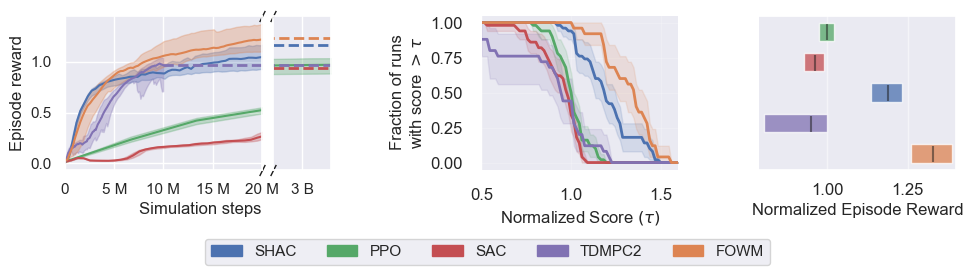

In [6]:
# Ant Figure
f, ax = plt.subplot_mosaic("0001..222.333", figsize=(11.5,2), sharey=False)
smooth=None
env = "ant"
    
for alg in ["ppo", "sac", "shac"]:
    print(f"alg={alg}")
    
    # load data
    col = "rewards" if alg in ["shac", "ahac"] else "rewards/time"
    data = process_time_data_iqm(f"data/{alg}_{env}_time.csv", sample_rates[env], col, smooth=smooth)

    if alg == "ppo":
        perf_scale = data[col].max()
        print("Perf scale", perf_scale)
        perf_scales.update({env:perf_scale})
        
    j = data[col].argmax()
    print("max reward {:3.2f}".format(data[col][j]/perf_scale))
    print("max std {:3.2f}".format(data[data.columns[data.columns.str.endswith(f"{col}")]].iloc[j].std()/perf_scale))
        
    # Scale data proportionally
    data[[col, f"{col}_max", f"{col}_min"]] /= perf_scale
        
    ### Plot against steps
    span = (0, 35e6) # AHAC range + some
    slice = data[(data.global_step >= span[0]).values & (data.global_step <= span[1]).values]
    ax['0'].plot(slice.global_step, slice[col], c=colors[alg.upper()])
    ax['0'].fill_between(slice.global_step, slice[f"{col}_min"], slice[f"{col}_max"], alpha=0.3, color=colors[alg.upper()])
    ax['0'].set_xlim((0, 30492000)) # AHAC span

    # Plot against very large steps. Only PPO gets plotted
    span = (3e9 - 10e6, 3e9 + 10e6)
    if alg in ["ppo"]:
        slice = data[(data.global_step > span[0]).values & (data.global_step < span[1]).values]
        ax['1'].plot(slice.global_step, slice[col], c=colors[alg.upper()])
        ax['1'].fill_between(slice.global_step, slice[f"{col}_min"], slice[f"{col}_max"], alpha=0.3, color=colors[alg.upper()])
    else:
        n = 5
        ax['1'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors[alg.upper()], lw=2)
    ax['1'].set_xlim((3e9 - 5e6, 3e9 + 5e6))


# plot TDMPC
col = "train/episode_reward"
data = process_step_data_iqm("data/tdmpc2_ant.csv", col=col, downsample=500, smooth=0.8)
data[f"{col}"] /= perf_scale
data[f"{col}_min"] /= perf_scale
data[f"{col}_max"] /= perf_scale
ax['0'].plot(data.index, data[col], color=colors["TDMPC2"])
ax['0'].fill_between(data.index, data[f"{col}_min"], data[f"{col}_max"], color=colors["TDMPC2"], alpha=0.3)
last = data.index[-1]
span = (last, span[1])
ax['0'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["TDMPC2"], lw=2)
ax['1'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["TDMPC2"], lw=2)

# plot FOWM
col = "rewards"
data = process_step_data_iqm("data/fowm_ant.csv", col=col, downsample=500, smooth=0.8)
data[f"{col}"] /= perf_scale
data[f"{col}_min"] /= perf_scale
data[f"{col}_max"] /= perf_scale
ax['0'].plot(data.index, data[col], color=colors["FOWM"])
ax['0'].fill_between(data.index, data[f"{col}_min"], data[f"{col}_max"], color=colors["FOWM"], alpha=0.3)
last = data.index[-1]
span = (last, span[1])
ax['0'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["FOWM"], lw=2)
ax['1'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["FOWM"], lw=2)

        
# Formatting
ax['0'].set_xlabel("Simulation steps", loc="right")
ax['0'].set_ylabel("Episode reward")
ax['0'].set_xlim((0, 20e6))
ax['0'].xaxis.set_major_formatter(ticker.EngFormatter())
ax['1'].xaxis.set_major_formatter(ticker.EngFormatter())
ax['1'].set_xlabel('')
ax['1'].get_yaxis().set_visible(False)
ax['1'].set_xticks([3e9])
ax['1'].set_ylim(ax['0'].get_ylim())


# add continuity ticks
d = 2.  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax['0'].plot([1, 1], [0, 1], transform=ax['0'].transAxes, **kwargs)
ax['1'].plot([0, 0], [0, 1], transform=ax['1'].transAxes, **kwargs)

# plot CI and median
h=0.6
labels = ["PPO", "SAC", "SHAC", "TDMPC2", "FOWM"][::-1]

plot_utils.plot_performance_profiles(
  score_distributions, tau,
  performance_profile_cis=score_distributions_cis,
  colors=colors,
  xlabel=r'PPO-normalized Score $(\tau)$',
  labelsize='medium',
  ax=ax['2'])
ax['2'].tick_params(axis='both', which='major', labelsize='medium')
ax['2'].set_xlabel(r'Normalized Score $(\tau)$', fontsize='medium')
ax['2'].set_ylabel('Fraction of runs\nwith score $> \\tau$', fontsize='medium')
ax['2'].set_xlim((0.5, 1.6))


for idx, alg in enumerate(labels):
    ax['3'].barh(y=idx, width=iqm_cis[alg][1] - iqm_cis[alg][0], height=0.6, left=iqm_cis[alg][0], alpha=0.75, color=colors[alg])
    ax['3'].vlines(x=iqm_scores[alg],
        ymin=idx - (7.5 * h / 16),
        ymax=idx + (6.5 * h / 16),
        color='k',
        alpha=0.5)

# cleanup grid and axis
ax['3'].spines['left'].set_visible(False)
ax['3'].grid(False)    
ax['3'].grid(True, axis='x', alpha=0.5)    
ax['3'].set_yticks([])
ax['3'].set_xlabel("Normalized Episode Reward", fontsize='medium')
ax['3'].tick_params(axis='both', which='major', labelsize='medium')
ax['3'].set_xlim((0.79, 1.4))


# plt.tight_layout(h_pad=10, w_pad=3)
plt.tight_layout()

# Create fancy legend
ax['1'].legend(handles=fancy_legend, loc='upper center', bbox_to_anchor=(3.7, -0.4),
          fancybox=True, shadow=False, ncol=5)
plt.savefig("../figures/dflex_results.pdf", bbox_inches="tight")

# Locomotion Sweep

=== Doing hopper ===
alg=ppo
perf_scale: 4742.296956380208
max reward 1.00
max std 0.11
alg=sac


/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_28829/2796463547.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("max reward {:3.2f}".format(data[col][j]/perf_scale))
/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_28829/2796463547.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("max reward {:3.2f}".format(data[col][j]/perf_scale))
/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_28829/2796463547.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

max reward 0.87
max std 0.16
alg=shac
max reward 1.02
max std 0.03
=== Doing anymal ===
alg=ppo
perf_scale: 12028.991672092014
max reward 1.00
max std 0.03
alg=sac


/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_28829/2796463547.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("max reward {:3.2f}".format(data[col][j]/perf_scale))
/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_28829/2796463547.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("max reward {:3.2f}".format(data[col][j]/perf_scale))


max reward 0.98
max std 0.06
alg=shac


/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_28829/2796463547.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("max reward {:3.2f}".format(data[col][j]/perf_scale))


max reward 1.26
max std 0.04
=== Doing humanoid ===
alg=ppo
perf_scale: 7292.7856852213545
max reward 1.00
max std 0.05
alg=sac


/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_28829/2796463547.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("max reward {:3.2f}".format(data[col][j]/perf_scale))
/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_28829/2796463547.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("max reward {:3.2f}".format(data[col][j]/perf_scale))


max reward 1.04
max std 0.04
alg=shac


/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_28829/2796463547.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("max reward {:3.2f}".format(data[col][j]/perf_scale))


max reward 1.15
max std 0.04
=== Doing humanoidsnu ===
alg=ppo
perf_scale: 4246.042073567708
max reward 1.00
max std 0.09
alg=sac


/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_28829/2796463547.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("max reward {:3.2f}".format(data[col][j]/perf_scale))
/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_28829/2796463547.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("max reward {:3.2f}".format(data[col][j]/perf_scale))
/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_28829/2796463547.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

max reward 0.88
max std 0.11
alg=shac
max reward 1.44
max std 0.08


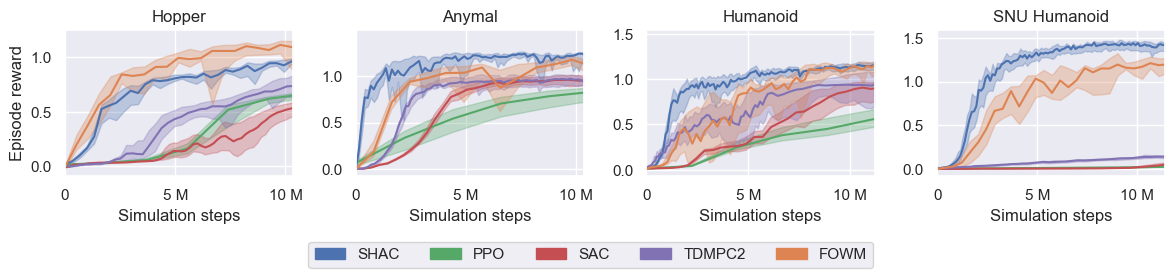

In [168]:
# load svg results seperately
iqm = lambda scores: trim_mean(scores, proportiontocut=0.25).flatten()

# pre-process SVG since it has more unique data
df = pd.read_csv("data/svg_results.csv")
df = df.drop("Unnamed: 0", axis=1)
svg_results = {}
for col in df.columns:
    vals = np.expand_dims(df[col].values, [1,2])
    iqm_scores, iqm_cis = rly.get_interval_estimates({0: vals}, iqm, reps=2000)
    svg_results.update({col: (iqm_scores[0], iqm_cis[0])})

f, ax = plt.subplots(1, 4, sharey=False, figsize=(12,2.5))
ax = ax.flatten()

smooth=None

for i, env in enumerate(["hopper", "anymal", "humanoid", "humanoidsnu"]):
    print(f"=== Doing {env} ===")
    
    for alg in ["ppo", "sac", "shac"]:
        print(f"alg={alg}")
        
        # load data
        col = "rewards/time" if alg in ["ppo", "sac"] else "rewards"
        data = process_time_data_iqm(f"data/{alg}_{env}_time.csv", sample_rates[env], col, smooth=smooth)

        if alg == "ppo":
            perf_scale = data[col].max()
            print("perf_scale:", perf_scale)
            perf_scales.update({env: perf_scale})
            
        j = data[col].argmax()
        print("max reward {:3.2f}".format(data[col][j]/perf_scale))
        print("max std {:3.2f}".format(data[data.columns[data.columns.str.endswith(f"{col}")]].iloc[j].std()/perf_scale))
            
        # Scale data proportionally
        data[[col, f"{col}_max", f"{col}_min"]] /= perf_scale
            
        # Plot against steps
        ax[i].plot(data.global_step, data[col], c=colors[alg.upper()])
        ax[i].fill_between(data.global_step, data[f"{col}_min"], data[f"{col}_max"], alpha=0.3, color=colors[alg.upper()])
        ax[i].set_xlabel("Simulation steps")
        ax[i].xaxis.set_major_formatter(ticker.EngFormatter())
        ax[i].set_xlim((0,data.global_step.max()))

        # # Plot against time
        # ax[i+4].plot(data.index.total_seconds()/60, data[col], c=colors[alg.upper()])
        # ax[i+4].fill_between(data.index.total_seconds()/60, data[f"{col}_min"], data[f"{col}_max"], alpha=0.3, color=colors[alg.upper()])
        # ax[i+4].set_xlabel("Time (min)")
        # ax[i+4].set_xlim((0,(data.index.total_seconds()/60).max()))


    if env in ["anymal"]:
        ds = 5
    else:
        ds=500

    # plot TDMPC
    col = "train/episode_reward"
    data = process_step_data_iqm(f"data/tdmpc2_{env}.csv", col=col, downsample=ds, smooth=0.6)
    data[f"{col}"] /= perf_scale
    data[f"{col}_min"] /= perf_scale
    data[f"{col}_max"] /= perf_scale
    ax[i].plot(data.index, data[col], color=colors["TDMPC2"])
    ax[i].fill_between(data.index, data[f"{col}_min"], data[f"{col}_max"], color=colors["TDMPC2"], alpha=0.3)
    # last = data.index[-1]
    # span = (last, span[1])
    # ax['0'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["TDMPC2"], lw=2)
    # ax['1'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["TDMPC2"], lw=2)

    if env in ["anymal", "humanoid", "humanoidsnu"]:
        ds = 50
    else:
        ds=500
    
    # plot FOWM
    col = "rewards"
    data = process_step_data_iqm(f"data/fowm_{env}.csv", col=col, downsample=ds)
    data[f"{col}"] /= perf_scale
    data[f"{col}_min"] /= perf_scale
    data[f"{col}_max"] /= perf_scale
    ax[i].plot(data.index, data[col], color=colors["FOWM"])
    ax[i].fill_between(data.index, data[f"{col}_min"], data[f"{col}_max"], color=colors["FOWM"], alpha=0.3)
    # last = data.index[-1]
    # span = (last, span[1])
    # ax['0'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["FOWM"], lw=2)
    # ax['1'].plot(np.linspace(span[0],span[1], n), data[f"{col}"].dropna().iloc[-1].repeat(n), '--', c=colors["FOWM"], lw=2)
        
    # # plot svg seperately
    # n = 50
    # mi, ma = ax[i].get_xlim()
    # xx = np.linspace(mi, ma, n)
    # ax[i].plot(xx, np.repeat(svg_results[env][0], n)/perf_scale, "--", c=colors["SVG"])
    
    # mi, ma = ax[i+4].get_xlim()
    # xx = np.linspace(mi, ma, n)
    # ax[i+4].plot(xx, np.repeat(svg_results[env][0], n)/perf_scale, "--", c=colors["SVG"])
    
    # print(f"svg max reward {svg_results[env][0]/perf_scale}")
            
        
# Final cleanup
ax[0].set_ylabel("Episode reward")
# ax[0+4].set_ylabel("Episode reward")
ax[0].set_title("Hopper")
ax[1].set_title("Anymal")
ax[2].set_title("Humanoid")
ax[3].set_title("SNU Humanoid")

# manual plot tuning
ax[0].set_xlim((0,10357184))
ax[1].set_xlim((0,10357184))
# ax[5].set_xlim((0,150))
# ax[6].set_xlim((0,150))

plt.tight_layout()

# Create fancy legend
ax[1].legend(handles=fancy_legend, loc='upper center', bbox_to_anchor=(1.03, -0.4),
          fancybox=True, shadow=False, ncol=5)
plt.savefig("../figures/locomotion_sweep.pdf", bbox_inches="tight")

# Stiffness experiment
Increase simulation stiffness to ke=1e5 and kd=1e4. Retrain all algorithms and see if PWM is better than SHAC at learning through  

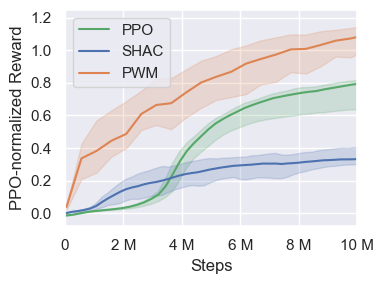

In [67]:
ppo_data = process_step_data_iqm("data/ppo_hopper_stiff.csv", row="global_step", col="rewards/step", downsample=1, smooth=0.7)
shac_data = process_step_data_iqm("data/shac_hopper_stiff.csv", row="global_step", col="rewards/step", smooth=0.7)
pwm_data = process_step_data_iqm("data/pwm_hopper_stiff.csv", row="Step", col="rewards", smooth=0.7)

norm = ppo_data["rewards/step"].max()
ppo_data /= norm
shac_data /= norm
pwm_data /= norm

f, ax = plt.subplots(1, 1, figsize=(4,3))
ax.plot(ppo_data["rewards/step"], label="PPO", color=colors["PPO"])
ax.fill_between(ppo_data.index, ppo_data["rewards/step_min"], ppo_data["rewards/step_max"], alpha=0.2, color=colors["PPO"])
ax.plot(shac_data["rewards/step"], label="SHAC", color=colors["SHAC"])
ax.fill_between(shac_data.index, shac_data["rewards/step_min"], shac_data["rewards/step_max"], alpha=0.2, color=colors["SHAC"])
ax.plot(pwm_data["rewards"], label="PWM", color=colors["FOWM"])
ax.fill_between(pwm_data.index, pwm_data["rewards_min"], pwm_data["rewards_max"], alpha=0.2, color=colors["FOWM"])
ax.set_xlim((0, 1e7))
ax.xaxis.set_major_formatter(ticker.EngFormatter())
# ax.yaxis.set_major_formatter(ticker.EngFormatter())
plt.xlabel("Steps")
plt.ylabel("PPO-normalized Reward")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/hopper_stiffness.pdf", bbox_inches="tight", pad_inches=0)